1. Resnet
        Accuracy: 0.8131
        Classification Report:
                    precision    recall  f1-score   support

                   0       0.85      0.88      0.86       144
                   1       0.73      0.69      0.71        70

            accuracy                           0.81       214
           macro avg       0.79      0.78      0.78       214
        weighted avg       0.81      0.81      0.81       214
        
        model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/orientation/orientation_pigmentation_forehead/model/model_v1/pigmentation_forehead_v2.pth'

2. DenseNet201 + orientation
        Accuracy: 0.9544
        Average Loss: 0.2550
        Classification Report:
                      precision    recall  f1-score   support

                   0       0.96      0.98      0.97       690
                   1       0.94      0.90      0.92       275

            accuracy                           0.95       965
           macro avg       0.95      0.94      0.94       965
        weighted avg       0.95      0.95      0.95       965

        model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ensemble/extra_forehead_pigmentation/model/model_v2/DenseNet201_42_ensemble_1.pth'

3. DenseNet201_VGG19(앙상블 모델) + orientation
        n = 2490
        val_n = 965
        test_n = 965
        
        Accuracy: 0.9482
        Average Loss: 0.2692
        Classification Report:
                    precision    recall  f1-score   support

                   0       0.96      0.97      0.96       690
                   1       0.92      0.90      0.91       275

            accuracy                           0.95       965
           macro avg       0.94      0.93      0.94       965
        weighted avg       0.95      0.95      0.95       965

        model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ensemble/extra_forehead_pigmentation/model/model_v2/DenseNet201_VGG19_42_ensemble_1.pth'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ResNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)

            # os.walk()를 사용하여 모든 하위 디렉토리와 파일 탐색
            for root, dirs, files in os.walk(image_folder):
                for image_file in files:
                    if image_file.endswith('.jpg'):
                        image_path = os.path.join(root, image_file)
                        image_id = image_file.split('_')[0]
                        label_data = df[df['ID'] == int(image_id)]['forehead_pigmentation'].values
                        if len(label_data) > 0:
                            label = label_data[0]
                            self.image_paths.append(image_path)
                            self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('YCbCr')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터셋 준비
csv_file = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv'
image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead'

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])


# 데이터셋 생성
train_dataset = SkinDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)

class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)
            for folder in image_folder:
                # os.walk()를 사용하여 모든 하위 디렉토리와 파일 탐색
                for root, dirs, files in os.walk(folder):
                    for image_file in files:
                        if image_file.endswith('.jpg'):
                            image_path = os.path.join(root, image_file)
                            image_id = image_file.split('_')[0]
                            label_data = df[df['ID'] == int(image_id)]['forehead_pigmentation'].values
                            if len(label_data) > 0:
                                label = label_data[0]
                                self.image_paths.append(image_path)
                                self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('YCbCr')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

val_dataset = SkinDataset(csv_file='/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv',
                          image_folder=[
                              '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/forehead/smart_pad',
                              '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/forehead/forehead_origin'
                          ],
                          transform=transform)


# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=3)


# 모델 정의
class ResNetforClassification(nn.Module):
    def __init__(self, num_classes, dropout_rate=dropout_rate, hidden_dim=hidden_dim):
        super(ResNetforClassification, self).__init__()
        # Pretrained ResNet50 모델 로드
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # ResNet50의 마지막 fc 레이어의 입력 차원 자동으로 가져오기
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Identity()  # Remove the classification head

        self.fc1 = nn.Linear(num_ftrs, hidden_dim)  # 중간 차원으로 64 선택 (언제나 바꿀 수 있음)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, num_classes)  # 최종 출력 차원은 클래스 수

    def forward(self, image):
        image_features = self.resnet50(image) # ResNet50을 통해 이미지 특징 추출
        x = self.fc1(image_features)
        x = torch.relu(x)
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc2(x) # 최종 FC 레이어
        return x

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([0.7807, 2.0104], dtype=torch.float32).to(device)

num_classes = 2  # 색소침착 등급이 2개
model = ResNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/orientation/orientation_pigmentation_forehead/model/model_v1/pigmentation_forehead_v2.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)

Epoch [1/50], Train Loss: 0.6145, Train Accuracy: 0.7288, Val Loss: 0.5608, Val Accuracy: 0.7336
Epoch [2/50], Train Loss: 0.4701, Train Accuracy: 0.7649, Val Loss: 0.5130, Val Accuracy: 0.7523
Epoch [3/50], Train Loss: 0.3414, Train Accuracy: 0.8444, Val Loss: 0.7423, Val Accuracy: 0.7944
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.2484, Train Accuracy: 0.8912, Val Loss: 0.6595, Val Accuracy: 0.7944
EarlyStopping counter: 2 out of 5
Epoch [5/50], Train Loss: 0.1585, Train Accuracy: 0.9371, Val Loss: 0.9578, Val Accuracy: 0.7944
EarlyStopping counter: 3 out of 5
Epoch [6/50], Train Loss: 0.1157, Train Accuracy: 0.9580, Val Loss: 0.9377, Val Accuracy: 0.7804
EarlyStopping counter: 4 out of 5
Epoch [7/50], Train Loss: 0.0866, Train Accuracy: 0.9721, Val Loss: 0.9652, Val Accuracy: 0.8131
EarlyStopping counter: 5 out of 5
Early stopping


Accuracy: 0.8131
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       144
           1       0.73      0.69      0.71        70

    accuracy                           0.81       214
   macro avg       0.79      0.78      0.78       214
weighted avg       0.81      0.81      0.81       214



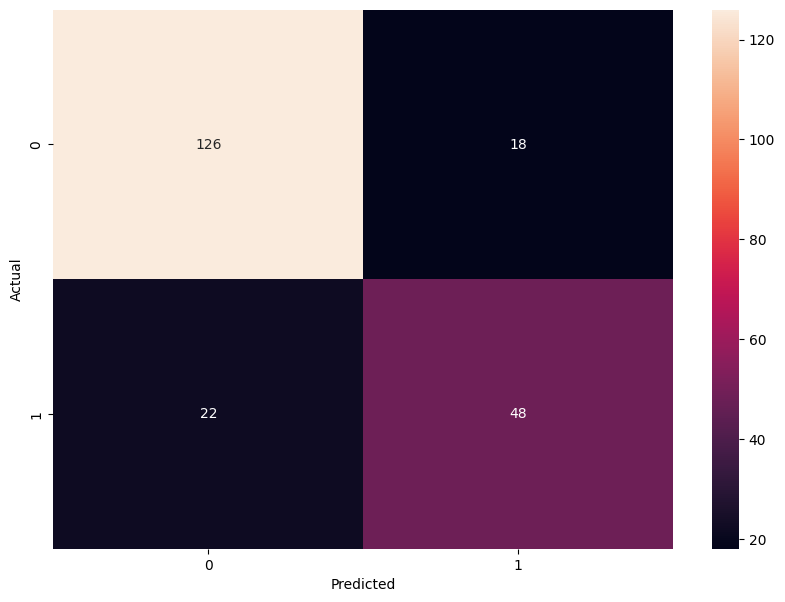

In [ ]:
#모델 평가
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

val_dataset = SkinDataset(csv_file='/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv',
                          image_folder=[
                              '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/forehead/smart_pad',
                              '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/forehead/forehead_origin'],
                          transform=transform)

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/orientation/orientation_pigmentation_forehead/model/model_v1/pigmentation_forehead_v2.pth'

# 모델 로드 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 모델 불러오기
model = ResNetforClassification(num_classes=2).to(device)
model= torch.load(model_save_path)
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # val_loader로 변경
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# DenseNet201 + orientation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import DenseNet121_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)
            for folder in image_folder:
                for image_file in os.listdir(folder):
                    if image_file.endswith('.jpg'):
                        image_path = os.path.join(folder, image_file)
                        image_id = image_file.split('_')[0]
                        label_data = df[df['ID'] == int(image_id)]['forehead_pigmentation'].values
                        if len(label_data) > 0:
                            label = label_data[0]
                            self.image_paths.append(image_path)
                            self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('YCbCr')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터셋 준비
csv_file = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv'
train_image_folder = [
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/color_minus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/color_plus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/rotation_minus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/rotation_plus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/forehead_origin',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/horizon'
                ]

val_image_folder = [
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/smart_pad',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/train/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/val/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/forehead/smart_pad',
                ]

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 데이터셋 생성
train_dataset = SkinDataset(csv_file=csv_file, image_folder  = train_image_folder, transform=transform)
val_dataset = SkinDataset(csv_file=csv_file, image_folder=val_image_folder, transform=transform)

# Validation 및 Test 데이터셋 분할
val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    val_dataset.image_paths, val_dataset.labels, test_size=0.5, random_state=1, stratify=val_dataset.labels
)

# Validation 및 Test 데이터셋 생성
validation_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)
test_dataset = SkinDataset(image_paths=test_image_paths, labels=test_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=3)
val_loader = DataLoader(validation_dataset, batch_size=10, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=3)

# DenseNet 기반 모델 정의
class DenseNetforClassification(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetforClassification, self).__init__()
        self.densenet = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        self.dropout = nn.Dropout(p = 0.4)  # 40% 드롭아웃
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1024, 512),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

# `device` 변수 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([1.0, 1.5], dtype=torch.float32).to(device)

num_classes = 2  # 주름 분류를 위한 클래스 수 (0과 1)
model = DenseNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ensemble/extra_forehead_pigmentation/model/model_v2/DenseNet201_42_ensemble_1.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)

Epoch [1/50], Train Loss: 0.5342, Train Accuracy: 0.7509, Val Loss: 0.3992, Val Accuracy: 0.8518
Epoch [2/50], Train Loss: 0.4136, Train Accuracy: 0.8218, Val Loss: 0.3270, Val Accuracy: 0.8850
Epoch [3/50], Train Loss: 0.2998, Train Accuracy: 0.8819, Val Loss: 0.3133, Val Accuracy: 0.8984
Epoch [4/50], Train Loss: 0.2181, Train Accuracy: 0.9157, Val Loss: 0.2415, Val Accuracy: 0.9316
Epoch [5/50], Train Loss: 0.1644, Train Accuracy: 0.9373, Val Loss: 0.2387, Val Accuracy: 0.9399
Epoch [6/50], Train Loss: 0.1074, Train Accuracy: 0.9589, Val Loss: 0.2368, Val Accuracy: 0.9409
Epoch [7/50], Train Loss: 0.0785, Train Accuracy: 0.9708, Val Loss: 0.2470, Val Accuracy: 0.9513
EarlyStopping counter: 1 out of 5
Epoch [8/50], Train Loss: 0.0509, Train Accuracy: 0.9837, Val Loss: 0.2405, Val Accuracy: 0.9503
EarlyStopping counter: 2 out of 5
Epoch [9/50], Train Loss: 0.0426, Train Accuracy: 0.9866, Val Loss: 0.2456, Val Accuracy: 0.9503
EarlyStopping counter: 3 out of 5
Epoch [10/50], Train Loss

Accuracy: 0.9544
Average Loss: 0.2550
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       690
           1       0.94      0.90      0.92       275

    accuracy                           0.95       965
   macro avg       0.95      0.94      0.94       965
weighted avg       0.95      0.95      0.95       965



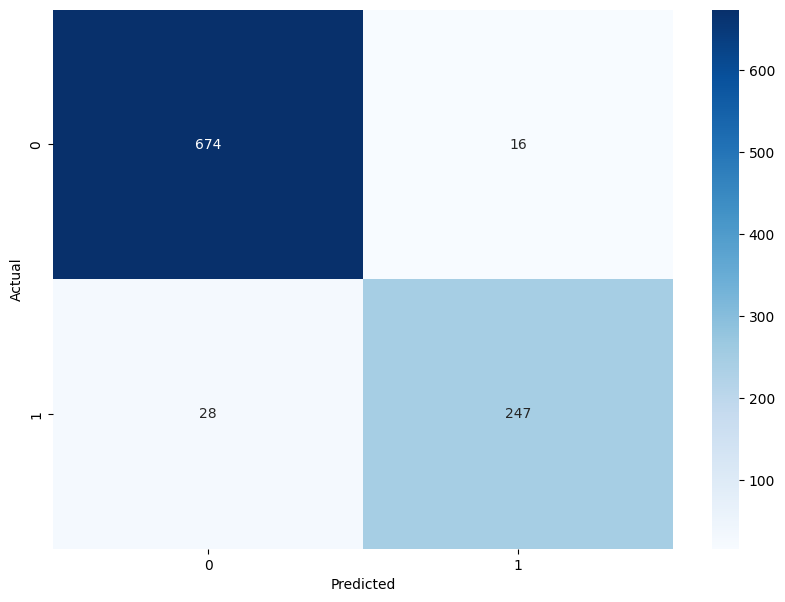

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# 모델 평가
model.eval()
# 검증 데이터셋에 대한 예측
true_labels = []
predicted_labels = []
all_losses = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # 손실 계산
        loss = F.cross_entropy(outputs, labels)
        all_losses.append(loss.item())

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
average_loss = sum(all_losses) / len(all_losses)

print(f'Accuracy: {accuracy:.4f}')
print(f'Average Loss: {average_loss:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# DenseNet201_VGG19(앙상블 모델) + orientation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import DenseNet201_Weights, VGG19_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)
            for folder in image_folder:
                for image_file in os.listdir(folder):
                    if image_file.endswith('.jpg'):
                        image_path = os.path.join(folder, image_file)
                        image_id = image_file.split('_')[0]
                        label_data = df[df['ID'] == int(image_id)]['forehead_pigmentation'].values
                        if len(label_data) > 0:
                            label = label_data[0]
                            self.image_paths.append(image_path)
                            self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터셋 준비
csv_file = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv'
train_image_folder = [
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/color_minus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/color_plus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/rotation_minus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/rotation_plus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/forehead_origin',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/horizon'
                ]

val_image_folder = [
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/smart_pad',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/train/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/val/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/forehead/smart_pad',
                ]

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 데이터셋 생성
train_dataset = SkinDataset(csv_file=csv_file, image_folder  = train_image_folder, transform=transform)
val_dataset = SkinDataset(csv_file=csv_file, image_folder=val_image_folder, transform=transform)

# Validation 및 Test 데이터셋 분할
val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    val_dataset.image_paths, val_dataset.labels, test_size=0.5, random_state=42, stratify=val_dataset.labels
)

# Validation 및 Test 데이터셋 생성
validation_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)
test_dataset = SkinDataset(image_paths=test_image_paths, labels=test_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=3)
val_loader = DataLoader(validation_dataset, batch_size=10, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=3)

# 앙상블 모델 정의
class DenseNet201_VGG19_Ensemble(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet201_VGG19_Ensemble, self).__init__()

        # DenseNet201 정의
        self.densenet = models.densenet201(weights=DenseNet201_Weights.DEFAULT)
        densenet_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()  # 최종 분류기를 제거하고 특징만 추출

        # VGG19 정의
        self.vgg = models.vgg19(weights=VGG19_Weights.DEFAULT)
        vgg_features = self.vgg.classifier[0].in_features
        self.vgg.classifier = nn.Identity()  # 최종 분류기를 제거하고 특징만 추출

        # 두 모델의 특징을 결합하는 계층
        self.classifier = nn.Sequential(
            nn.Linear(densenet_features + vgg_features, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # DenseNet201 특징 추출
        densenet_features = self.densenet(x)

        # VGG19 특징 추출
        vgg_features = self.vgg(x)

        # 두 특징을 결합
        combined_features = torch.cat((densenet_features, vgg_features), dim=1)

        # 최종 분류
        output = self.classifier(combined_features)
        return output

# `device` 변수 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([1.2, 2.0], dtype=torch.float32).to(device)

num_classes = 2  # 주름 분류를 위한 클래스 수 (0과 1)
model = DenseNet201_VGG19_Ensemble(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ensemble/extra_forehead_pigmentation/model/model_v2/DenseNet201_VGG19_42_ensemble_1.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 185MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 221MB/s]


Epoch [1/50], Train Loss: 0.5584, Train Accuracy: 0.7471, Val Loss: 0.5756, Val Accuracy: 0.6280
Epoch [2/50], Train Loss: 0.4159, Train Accuracy: 0.8256, Val Loss: 0.3433, Val Accuracy: 0.8415
Epoch [3/50], Train Loss: 0.2842, Train Accuracy: 0.8868, Val Loss: 0.2462, Val Accuracy: 0.9316
Epoch [4/50], Train Loss: 0.1464, Train Accuracy: 0.9466, Val Loss: 0.2689, Val Accuracy: 0.9420
EarlyStopping counter: 1 out of 5
Epoch [5/50], Train Loss: 0.0788, Train Accuracy: 0.9729, Val Loss: 0.2513, Val Accuracy: 0.9565
EarlyStopping counter: 2 out of 5
Epoch [6/50], Train Loss: 0.0446, Train Accuracy: 0.9848, Val Loss: 0.2081, Val Accuracy: 0.9492
Epoch [7/50], Train Loss: 0.0215, Train Accuracy: 0.9950, Val Loss: 0.3034, Val Accuracy: 0.9534
EarlyStopping counter: 1 out of 5
Epoch [8/50], Train Loss: 0.0111, Train Accuracy: 0.9974, Val Loss: 0.2902, Val Accuracy: 0.9523
EarlyStopping counter: 2 out of 5
Epoch [9/50], Train Loss: 0.0186, Train Accuracy: 0.9950, Val Loss: 0.3246, Val Accuracy

Accuracy: 0.9482
Average Loss: 0.2692
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       690
           1       0.92      0.90      0.91       275

    accuracy                           0.95       965
   macro avg       0.94      0.93      0.94       965
weighted avg       0.95      0.95      0.95       965



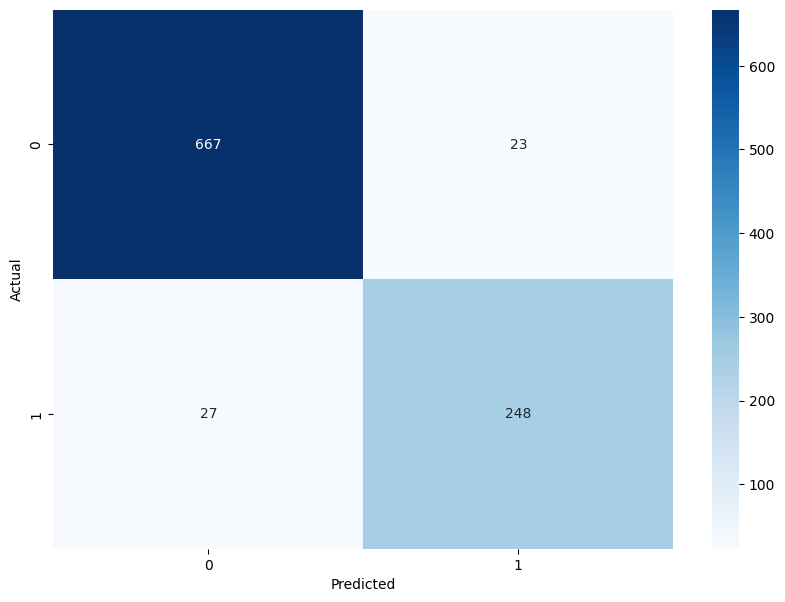

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# 모델 평가
model.eval()
# 검증 데이터셋에 대한 예측
true_labels = []
predicted_labels = []
all_losses = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # 손실 계산
        loss = F.cross_entropy(outputs, labels)
        all_losses.append(loss.item())

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
average_loss = sum(all_losses) / len(all_losses)

print(f'Accuracy: {accuracy:.4f}')
print(f'Average Loss: {average_loss:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()